# Pymeos and Pyspark Partitioning Demo

First we perform the corresponding imports for the libraries to use.

In [1]:
from pymeos import *
from pysparkmeos.UDT.MeosDatatype import *

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.serializers import PickleSerializer
import pyspark.sql.functions as F

from pyspark.storagelevel import StorageLevel

from pysparkmeos.partitions.grid.grid_partitioner import GridPartition

from pysparkmeos.utils.udt_appender import udt_append
from pysparkmeos.UDF.udf import *
from pysparkmeos.partitions.mobilityrdd import MobilityRDD

import random, datetime

from datetime import timedelta
from functools import partial
from datetime import datetime, timezone
import contextily as cx
import distinctipy
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry as shp
from pymeos.plotters import (
    TemporalPointSequenceSetPlotter,
    TemporalPointSequencePlotter,
)

import matplotlib.pyplot as plt
import numpy as np
import os, sys
from shapely import wkb, box
import pandas as pd
from functools import reduce

## Initialize Pymeos and setup Pyspark

In [2]:
# Initialize PyMEOS
pymeos_initialize("UTC")

os.environ['PYSPARK_DRIVER_PYTHON_OPTS']= "notebook"
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_PYTHON'] = sys.executable

#.config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("PySpark UDF Example with PyMEOS") \
    .master("local[3]") \
    .config("spark.default.parallelism", 3) \
    .config("spark.executor.memory", "3g") \
    .config("spark.executor.cores", 1) \
    .config("spark.driver.memory", "2g") \
    .config("spark.driver.maxResultSize", 0) \
    .config("spark.sql.allowMultipleTableArguments.enabled", True) \
    .getOrCreate()

#spark.sparkContext.setLogLevel("DEBUG")

# Append the UDT mapping to the PyMEOS classes
udt_append()

# Get the value of 'spark.default.parallelism'
print(spark.sparkContext.getConf().getAll())
#print(f"spark.default.parallelism: {default_parallelism}")
#print(f"spark.sql.allowMultipleTableArguments.enabled: {spark.sparkContext.getConf().get('spark.sql.allowMultipleTableArguments.enabled')}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/17 14:33:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/17 14:33:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


[('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'), ('spark.executor.memory', '3g'), ('spark.sql.allowMultipleTableArguments.enabled', 'true'), ('spark.app.s

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 58776)
Traceback (most recent call last):
  File "/usr/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.9/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.9/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.9/socketserver.py", line 720, in __init__
    self.handle()
  File "/usr/local/lib/python3.9/dist-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/usr/local/lib/python3.9/dist-packages/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/usr/local/lib/python3.9/dist-packages/pyspark/accumulators.py", line 271, in accum_updates
    num_updates = read_int(self.rf

## Read the DataFrame and create the columns of Pymeos data objects

First, we are going to read a dataset from OpenSky, this dataset cointains the trajectory information of multiple flights within a timeframe.  

Using the latitude, longitude and timestamp we can create a PyMEOS TGeogPointInst, that in PySpark will be wrapped into a TGeogPointInstUDT object.

In [3]:
# Read data from a CSV file
#data_path = "../../small_mid_states_2022-06-27-00.csv"  # Update this with your CSV file path
data_path = "../../sample.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True, mode='PERMISSIVE').select("icao24", "time", "lat", "lon")

# Clean nans, if not Points can't be created
df = df.dropna(subset=["lat", "lon", "time", "icao24"])

    #.withColumn("Point", F.concat(F.lit("Point("), F.col("lat"), F.lit(" "), F.col("lon"), F.lit(")@"), F.col("time"))) \
# Convert the 'time' column to the correct format
df = df \
    .withColumn("time", F.from_unixtime(F.col("time"), "yyyy-MM-dd' 'HH:mm:ss")) \
    .withColumn("lat", F.round("lat", 2)) \
    .withColumn("lon", F.round("lon", 2)) \
    .withColumn("Point", create_point_udf("lat", "lon", "time")) \
    .withColumn("x", get_point_x("Point")) \
    .withColumn("y", get_point_y("Point")) \
    .withColumn("t", get_point_timestamp("Point")) \
    .withColumn("id", F.monotonically_increasing_id())

#    .withColumn("x", get_point_x("Point")) \
#    .withColumn("y", get_point_y("Point")) \
#    .withColumn("t", get_point_timestamp("Point")) \
# df.createOrReplaceTempView("rawPoints")

df.tail(5)

#for row in df.toLocalIterator():
#    print(row)

24/05/17 14:33:31 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


[Row(icao24='a00529', time='2022-06-27 00:00:55', lat=-25.02, lon=120.0, Point=TGeomPointInstWrap(POINT(120 -25.02)@2022-06-27 00:00:55+00), x=120.0, y=-25.020000457763672, t=datetime.datetime(2022, 6, 27, 0, 0, 55), id=1),
 Row(icao24='a00529', time='2022-06-27 00:00:58', lat=80.0, lon=10.0, Point=TGeomPointInstWrap(POINT(10 80)@2022-06-27 00:00:58+00), x=10.0, y=80.0, t=datetime.datetime(2022, 6, 27, 0, 0, 58), id=2),
 Row(icao24='a00528', time='2022-06-27 00:00:10', lat=0.0, lon=-75.5, Point=TGeomPointInstWrap(POINT(-75.5 0)@2022-06-27 00:00:10+00), x=-75.5, y=0.0, t=datetime.datetime(2022, 6, 27, 0, 0, 10), id=3),
 Row(icao24='a00528', time='2022-06-27 00:00:20', lat=37.72, lon=-5.5, Point=TGeomPointInstWrap(POINT(-5.5 37.72)@2022-06-27 00:00:20+00), x=-5.5, y=37.720001220703125, t=datetime.datetime(2022, 6, 27, 0, 0, 20), id=4),
 Row(icao24='a00528', time='2022-06-27 00:00:30', lat=25.72, lon=12.5, Point=TGeomPointInstWrap(POINT(12.5 25.72)@2022-06-27 00:00:30+00), x=12.5, y=25.71

In [4]:
#df.rdd.getNumPartitions()

Handling a dataset like this gives us granularity over the datapoints, but it would be better to group the trajectories together using another function, this will return the TGeogPointSeq objects representing each trajectory. Let's create a UDTF that takes the icao24, and Point, and creates a new table with icao24, and PointSeq.

In [5]:
schema = StructType([
    StructField("icao24", StringType()),
    StructField("PointSeq", TGeomPointSeqUDT())
])


@F.udf(returnType=TGeomPointSeqUDT())
def pointSeqFromPoints(pointgroup):
    if not pointgroup:
        return None
    pymeos_initialize()
    if len(pointgroup) == 1:
        pointgroup = f'[{pointgroup[0].__str__()}]'
        return TGeomPointSeq(pointgroup)
    pointgroup = sorted(pointgroup, key=lambda x: x.timestamps()[0])
    pointseq = TGeomPointSeq(instant_list=pointgroup)
    return pointseq

print(df.count())

#df.select("Point").tail(5)
df.groupBy("icao24").agg(F.count("Point").alias("cnt")).orderBy("cnt",ascending=False).show()

trajectories = df.groupBy("icao24").agg(
    F.collect_list(F.col("Point")).alias("PointSeq")
).select("icao24", "PointSeq").withColumn("PointSeq", pointSeqFromPoints("PointSeq"))

print(trajectories.count())

trajectories.show(5)
trajectories.collect()[0].PointSeq
#trajectories.rdd.getNumPartitions()

#spark.sparkContext.setCheckpointDir("./checkpoint")
#trajectories = trajectories.checkpoint()
#trajectories.tail(1).limit(1).collect()[0].PointSeq

6


+------+---+
|icao24|cnt|
+------+---+
|a00528|  3|
|a00529|  3|
+------+---+



2
+------+--------------------+
|icao24|            PointSeq|
+------+--------------------+
|a00528|[POINT(-75.5 0)@2...|
|a00529|[POINT(-81.5 28.7...|
+------+--------------------+



TGeomPointSeqWrap([POINT(-75.5 0)@2022-06-27 00:00:10+00, POINT(-5.5 37.72)@2022-06-27 00:00:20+00, POINT(12.5 25.72)@2022-06-27 00:00:30+00))

This has reduced the table from 530k Points to 7k PointSeq!

In [6]:
# trajectories.createOrReplaceTempView("trajectories")

Now we need to calculate the boundaries of the whole space of trajectories.

In [7]:
from pymeos import TPoint

@F.udf(returnType=STBoxUDT())
def point_to_stbox(tpoint: TPoint) -> STBox:
    pymeos_initialize()
    return tpoint.bounding_box()

trajectories = trajectories.withColumn("STBox", point_to_stbox("PointSeq")).withColumn("seqId", F.monotonically_increasing_id())
trajectories.createOrReplaceTempView("trajectories")
trajectories.show()
trajectories.cache()
print(trajectories.count())
#trajectories.rdd.getNumPartitions()

+------+--------------------+--------------------+-----+
|icao24|            PointSeq|               STBox|seqId|
+------+--------------------+--------------------+-----+
|a00528|[POINT(-75.5 0)@2...|STBOX XT(((-75.5,...|    0|
|a00529|[POINT(-81.5 28.7...|STBOX XT(((-81.5,...|    1|
+------+--------------------+--------------------+-----+



2


In [8]:
def bounds_calculate_map(partition_rows):
    pymeos_initialize("UTC")
    aggregator = TemporalPointExtentAggregator.start_aggregation()
    #print(iter(partition_rows))
    for row in partition_rows:
        if type(row) == Row:
            #print(row)
            seq = TGeomPointSeq(row.PointSeq.__str__())
            aggregator.add(seq)
    try:
        boundbox = STBoxWrap(aggregator.aggregation().__str__())
        return [(boundbox)]#[(boundbox)]
    except:
        return [(None)]


def bounds_calculate_reduce(bounds1, bounds2):
    pymeos_initialize("UTC")
    aggregation = None
    
    if bounds1 and bounds2:
        aggregation = bounds1 + bounds2
    elif not bounds1 and bounds2:
        aggregation = bounds2
    elif not bounds2:
        aggregation = bounds1

    if aggregation:
        boundbox = STBoxWrap(aggregation.__str__())
        return boundbox
    else:
        return None


bounds = trajectories.rdd.mapPartitions(bounds_calculate_map).reduce(bounds_calculate_reduce)
bounds

STBoxWrap(STBOX XT(((-81.5,-25.02),(120,80)),[2022-06-27 00:00:10+00, 2022-06-27 00:00:58+00)))

In [9]:
#bounds = STBoxWrap(
#        "SRID=0;STBOX XT(((-177.02969360351562,-46.421356201171875),(177.816650390625,70.29727935791016)),[2022-06-27 00:00:00+00, 2022-06-27 00:15:00+00])",
#        geodetic=False)
#bounds

## Generate the partitioning scheme and repartition data

In [10]:
# Now we calculate the grid and partition accordingly
gp = GridPartition(cells_per_side=3, bounds=bounds.expand(10.0))
grid = gp.as_spark_table()
grid.cache()
grid.show()
grid.createOrReplaceTempView("grid")
#grid.rdd.getNumPartitions()

+------+--------------------+
|tileid|                tile|
+------+--------------------+
|     0|STBOX XT(((-91.5,...|
|     1|STBOX XT(((-91.5,...|
|     2|STBOX XT(((-91.5,...|
|     3|STBOX XT(((-91.5,...|
|     4|STBOX XT(((-91.5,...|
|     5|STBOX XT(((-91.5,...|
|     6|STBOX XT(((-91.5,...|
|     7|STBOX XT(((-91.5,...|
|     8|STBOX XT(((-91.5,...|
|     9|STBOX XT(((-17.66...|
|    10|STBOX XT(((-17.66...|
|    11|STBOX XT(((-17.66...|
|    12|STBOX XT(((-17.66...|
|    13|STBOX XT(((-17.66...|
|    14|STBOX XT(((-17.66...|
|    15|STBOX XT(((-17.66...|
|    16|STBOX XT(((-17.66...|
|    17|STBOX XT(((-17.66...|
|    18|STBOX XT(((56.166...|
|    19|STBOX XT(((56.166...|
+------+--------------------+
only showing top 20 rows



24/05/17 14:34:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [11]:
%time
from pyspark.sql.types import Row
from typing import Iterator

schema = StructType([
    StructField("trajectoryId", StringType()),
    StructField("partitionKey", IntegerType()),
    StructField("trajectory", TGeogPointSeqUDT())
])

@F.udtf(returnType=schema)
class RegularPartition:
    def eval(self, row: Row):
        pymeos_initialize()
        sequence_id = row.seqId
        trajectory = row.trajectory
        #print(trajectory,type(trajectory))
        #print(row.grid[0])
        #grid = [STBoxWrap(f"SRID=4326;{tile.__str__().strip('SRID=4326;')}") for tile in row.grid]
        grid = row.grid
        gridids = row.gridids
        partitioned = [(key, trajectory.at(tile)) for key, tile in zip(gridids, grid)]
        #print(trajectory)
        #print(grid)
        #print(partitioned)
        count = 0
        responses = []
        for partition_key, partition_traj in partitioned:
            count += 1
            if partition_traj is None:
                continue
            else:
                #responses.append((sequence_id, partition_key, partition_traj,))
                seqs = partition_traj.segments()
                #print(seqs)
                for partition_traj_seq in seqs:
                    responses.append((sequence_id, partition_key, partition_traj_seq,))
        for response in responses:
            yield response


spark.udtf.register("regularPartition", RegularPartition)

# spark.sql("SELECT collect_list(tile) FROM grid").show()

#spark.sql("SELECT seqId, PointSeq AS trajectory, (SELECT collect_list(tile) FROM grid) AS grid FROM trajectories").collect()

trajectoriesPartMap = spark.sql("""
    SELECT * 
    FROM regularPartition(
        TABLE(
                SELECT 
                    seqId, 
                    PointSeq AS trajectory, 
                    (SELECT collect_list(tile) FROM grid) AS grid, 
                    (SELECT collect_list(tileid) FROM grid) AS gridids
                FROM trajectories
        )
    )
""")

#trajectoriesPartMap.createOrReplaceTempView("trajectoriesPartMap")

#spark.sql(f"""
#    CREATE TABLE trajectoriesPart
#    USING parquet
#    PARTITIONED BY (partitionKey)
#    AS SELECT * FROM trajectoriesPartMap
#""")

#trajectoriesPartMap = spark.table('trajectoriesPart')
#print(trajectoriesPartMap.rdd.getNumPartitions())

#num_partitions = gp.num_partitions()

#trajectoriesPart = trajectoriesPartMap.rdd.mapPartitions(lambda row: (row['partitionKey'], row)).partitionBy(num_partitions)

#spark.sparkContext.setLogLevel("WARN")

#print(trajectoriesPartMap.tail(1))
#print(trajectoriesPartMap.count())
#trajectoriesPartMap.createOrReplaceTempView("trajectoriesPartMap")
#print(trajectoriesPartMap.rdd.getNumPartitions())
num_partitions = gp.num_partitions()
#trajectoriesPartMap = trajectoriesPartMap.withColumn("trajectory", F.col("trajectory").cast("string"))
trajectoriesPartMap.printSchema()

#trajectoriesPartMap = trajectoriesPartMap.repartition(num_partitions, "partitionKey")

def map_partition_rdd(index, rows):
    for row in rows:
        yield (row['partitionKey'], row)

trajectoriesPartMapRdd = trajectoriesPartMap.rdd.mapPartitionsWithIndex(map_partition_rdd).partitionBy(num_partitions)

#trajectoriesPartMap.cache()
#trajectoriesPartMap.show()

#for row in trajectoriesPartMapRdd.take(1):
#    print(row)

#trajectoriesPartMap = trajectoriesPartMapRdd.toDF(["partitionKey", "trajectorydata"]) #.withColumn("trajectory", F.col("trajectorydata.trajectory").cast(TGeogPointSeqUDT())).withColumn("trajectoryId", F.col("trajectorydata.trajectoryId")).drop("trajectorydata")
#trajectoriesPartMap.printSchema()
#trajectoriesPart.groupBy("trajectoryId").agg(F.count(F.col("trajectory")).alias("cnt")).orderBy("cnt", ascending=False).show()
#trajectoriesPartMap.orderBy("trajectoryId")
#trajectoriesPartMap.show()
#print(trajectoriesPartMap.rdd.getNumPartitions())

#RegularPartition(trajectories, trajectories.select("PointSeq"), F.lit(gp.gridstr)).show()


#spark.udtf.register("regularPartition", RegularPartition)


#print(gp.num_partitions())
#num_partitions = gp.num_partitions()
#gridstr = gp.gridstr

# Register the udf
#get_partition_key_udf = udf(gp.get_partition, IntegerType())

#dfpoint = df.select("id", "Point", "PointStr").withColumn("partitionKey", get_partition_key_udf(col("Point"), lit(gridstr)))
#dfpoint.show()

# dfpoint.select("_metadata").show(truncate=False)

CPU times: user 29 µs, sys: 27 µs, total: 56 µs
Wall time: 134 µs
root
 |-- trajectoryId: string (nullable = true)
 |-- partitionKey: integer (nullable = true)
 |-- trajectory: pythonuserdefined (nullable = true)



In [12]:
%%time
from pyspark.sql import SQLContext

#trajectoriesPart = spark.table("trajectoriesPart")

#print(trajectoriesPart.tail(5))
#print(trajectoriesPart.count())
#print(trajectoriesPartMap.rdd.getNumPartitions())


# This operation can be costly, for testing do with few data points (<= 1000).
num_partitions = gp.num_partitions()
#trajectoriesPart = trajectoriesPart.repartition(num_partitions, "partitionKey")
#print(trajectoriesPart.rdd.getNumPartitions())
#trajectoriesPartRdd = trajectoriesPart.rdd.map(lambda x: (x['partitionKey'], x)).partitionBy(num_partitions)
trajectoriesPartMap = trajectoriesPartMapRdd.toDF(["partitionKey", "trajectorydata"]).withColumn("trajectory", F.col("trajectorydata.trajectory")).withColumn("trajectoryId", F.col("trajectorydata.trajectoryId")).drop("trajectorydata")
#trajectoriesPart.groupBy("trajectoryId").agg(F.count(F.col("trajectory")).alias("cnt")).orderBy("cnt", ascending=False).show()
trajectoriesPartMap.orderBy("trajectoryId").cache()
trajectoriesPartMap.show()

+------------+--------------------+-------------+
|partitionKey|          trajectory| trajectoryId|
+------------+--------------------+-------------+
|           0|[POINT(-75.5 0)@2...| 326417514496|
|           3|[POINT(-63.152882...| 326417514496|
|           3|[POINT(-81.5 28.7...|1005022347264|
|          10|[POINT(1.26182633...|1005022347264|
|          12|[POINT(-17.666672...| 326417514496|
|          12|[POINT(-5.5 37.72...| 326417514496|
|          12|[POINT(-17.666667...|1005022347264|
|          13|[POINT(5.30000000...| 326417514496|
|          13|[POINT(-9.8555555...|1005022347264|
|          14|[POINT(56.16667 3...|1005022347264|
|          17|[POINT(43.1753033...|1005022347264|
|          19|[POINT(56.1666627...|1005022347264|
|          20|[POINT(61.7888888...|1005022347264|
|          20|[POINT(120 -25.02...|1005022347264|
|          23|[POINT(86.8247333...|1005022347264|
+------------+--------------------+-------------+

CPU times: user 333 ms, sys: 49.2 ms, total: 382 

## Show the partition distribution

In [13]:
%%time

trajectoriesPartMap.groupBy("partitionKey").count().show()

#for idx, item in datardd.take(5):
#    print(idx, item)

trajectoriesPartRdd = trajectoriesPartMap.rdd
print(trajectoriesPartRdd.getNumPartitions())

# Function to count rows per partition
def count_in_partition(idx, iterator):
    cnt = 0
    for _ in iterator:
        cnt += 1
    return [(idx, cnt)]

# Using mapPartitionsWithIndex to count rows per partition
partition_counts = trajectoriesPartRdd.mapPartitionsWithIndex(count_in_partition).collect()
    
# Print the results
for partition_id, cnt in partition_counts:
    print(f"Partition {partition_id} has {cnt} rows")


trajectoriesPartMap.show()

+------------+-----+
|partitionKey|count|
+------------+-----+
|           0|    1|
|           3|    2|
|          10|    1|
|          12|    3|
|          13|    2|
|          14|    1|
|          17|    1|
|          19|    1|
|          20|    2|
|          23|    1|
+------------+-----+

27


Partition 0 has 1 rows
Partition 1 has 0 rows
Partition 2 has 0 rows
Partition 3 has 2 rows
Partition 4 has 0 rows
Partition 5 has 0 rows
Partition 6 has 0 rows
Partition 7 has 0 rows
Partition 8 has 0 rows
Partition 9 has 0 rows
Partition 10 has 1 rows
Partition 11 has 0 rows
Partition 12 has 3 rows
Partition 13 has 2 rows
Partition 14 has 1 rows
Partition 15 has 0 rows
Partition 16 has 0 rows
Partition 17 has 1 rows
Partition 18 has 0 rows
Partition 19 has 1 rows
Partition 20 has 2 rows
Partition 21 has 0 rows
Partition 22 has 0 rows
Partition 23 has 1 rows
Partition 24 has 0 rows
Partition 25 has 0 rows
Partition 26 has 0 rows


+------------+--------------------+-------------+
|partitionKey|          trajectory| trajectoryId|
+------------+--------------------+-------------+
|           0|[POINT(-75.5 0)@2...| 326417514496|
|           3|[POINT(-63.152882...| 326417514496|
|           3|[POINT(-81.5 28.7...|1005022347264|
|          10|[POINT(1.26182633...|1005022347264|
|          12|[POINT(-17.666672...| 326417514496|
|          12|[POINT(-5.5 37.72...| 326417514496|
|          12|[POINT(-17.666667...|1005022347264|
|          13|[POINT(5.30000000...| 326417514496|
|          13|[POINT(-9.8555555...|1005022347264|
|          14|[POINT(56.16667 3...|1005022347264|
|          17|[POINT(43.1753033...|1005022347264|
|          19|[POINT(56.1666627...|1005022347264|
|          20|[POINT(61.7888888...|1005022347264|
|          20|[POINT(120 -25.02...|1005022347264|
|          23|[POINT(86.8247333...|1005022347264|
+------------+--------------------+-------------+

CPU times: user 211 ms, sys: 26.7 ms, total: 238 

## Plot the Projection of the grid and the distribution of data

root
 |-- partitionKey: long (nullable = true)
 |-- trajectory: pythonuserdefined (nullable = true)
 |-- trajectoryId: string (nullable = true)



/tmp/ipykernel_6800/2912954134.py:9: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


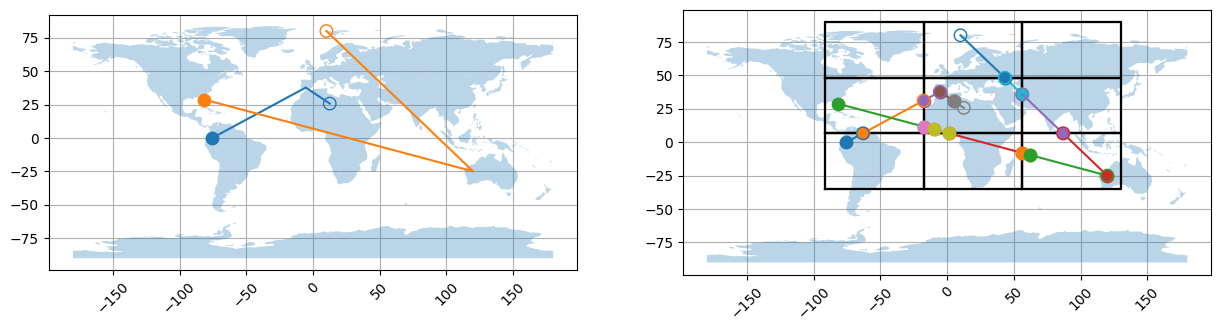

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# dfpoint = datardd.toDF(['partitionKey', 'Point'])
trajectoriesPartMap.printSchema()

# Create a bounding box
# bounding_box = box(bounds.xmin(), bounds.ymin(), bounds.xmax(), bounds.ymax())

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax[1], alpha=0.3)
world.plot(ax=ax[0], alpha=0.3)
#print(grid)
gridstr = [row.tile.__str__() for row in grid.collect()]

colors = plt.cm.Accent(np.linspace(0, 1, len(gridstr)))
# Adding an alpha value when creating the color ma<p
alpha_value = 1.0
color_map = {i: colors[i][:3].tolist() + [alpha_value] for i, tile in enumerate(gridstr)}
for i, tilestr in enumerate(gridstr):
    tile: STBox = STBoxWrap(tilestr).set_srid(0)
    tile.plot_xy(axes=ax[1], color="black", draw_filling=False)

trajectory_colors = ['red', 'green', 'blue', 'yellow', 'orange', 'pink', 'lightgreen', 'darkblue']
trajectory_idx = {}
for idx, row in enumerate(trajectoriesPartMap.toLocalIterator()):
    #print(row.trajectoryId, row.partitionKey)
    if row.trajectoryId in trajectory_idx:
        c = trajectory_idx[row.trajectoryId]
    else:
        c = idx
        trajectory_idx[row.trajectoryId] = idx
    traj = row.trajectory
    #print(idx, row.partitionKey%gp.num_partitions())
    #print(traj)
    #if type(point)==str:
    #    point = TGeogPointInst(point)
    #tpointseq = point.to_sequence(interp).plot(axes=ax,label="tpoint", color=color_map[row.partitionKey % gp.num_partitions()], facecolors='none')
    #TemporalPointSequenceSetPlotter.plot_xy(
    #    traj, axes=ax, show_markers=True, show_grid=False
    #)
    TemporalPointSequencePlotter.plot_xy(
        traj, axes=ax[1], show_markers=True, show_grid=True 
    )

for idx, row in enumerate(trajectories.toLocalIterator()):
    if row.icao24 in trajectory_idx:
        c = trajectory_idx[row.icao24]
    else:
        c = idx
        trajectory_idx[row.icao24] = idx
    TemporalPointSequencePlotter.plot_xy(
        row.PointSeq, axes=ax[0], show_markers=True, show_grid=True 
    )
    #row.PointSeq.plot(axes=ax[0],label="trajectory", color=trajectory_colors[c%len(trajectory_colors)], show_markers=True)


In [15]:
"""
import pandas as pd
from functools import reduce
from pymeos import *
import pickle
from pysparkmeos.UDT.MeosDatatype import *
from pysparkmeos.partitions.grid.grid_partitioner import *


pymeos_initialize("UTC")
#point = TGeogPointSeq('SRID=4326;[POINT(-96.93 41.61)@2022-06-27 00:00:55+00)')
#print(point)
tseq = TGeogPointSeq(string='SRID=4326;[POINT(-81.5 28.73)@2022-06-27 00:00:10+00, POINT(-81.5 28.72)@2022-06-27 00:00:20+00, POINT(-81.48 28.7)@2022-06-27 00:00:40+00, POINT(-81.48 28.69)@2022-06-27 00:00:50+00, POINT(30.45 -70.02)@2022-06-27 00:00:55+00)')
print(tseq.srid())
#tseq = tseq.set_srid(0)
bounds = STBox(
        "STBOX XT(((-177.02969360351562,-46.421356201171875),(177.816650390625,70.29727935791016)),[2022-06-27 00:00:00+00, 2022-06-27 00:15:00+00])").set_srid(0)
gp = GridPartition(cells_per_side=3, bounds=bounds)
print(gp.gridstr)
grid = [STBox(f"SRID=4326;GEOD{tile.__str__().replace('GEOD', '').replace('SRID=4326;', '')}") for tile in gp._generate_grid(bounds, 3, geodetic=True)]
for tile in grid:
    print(tile, tile.srid())
for key, tile in enumerate(grid):
    if tseq.at(tile) is not None:
        print("Attempting: ", key, tseq.at(tile))
"""

'\nimport pandas as pd\nfrom functools import reduce\nfrom pymeos import *\nimport pickle\nfrom pysparkmeos.UDT.MeosDatatype import *\nfrom pysparkmeos.partitions.grid.grid_partitioner import *\n\n\npymeos_initialize("UTC")\n#point = TGeogPointSeq(\'SRID=4326;[POINT(-96.93 41.61)@2022-06-27 00:00:55+00)\')\n#print(point)\ntseq = TGeogPointSeq(string=\'SRID=4326;[POINT(-81.5 28.73)@2022-06-27 00:00:10+00, POINT(-81.5 28.72)@2022-06-27 00:00:20+00, POINT(-81.48 28.7)@2022-06-27 00:00:40+00, POINT(-81.48 28.69)@2022-06-27 00:00:50+00, POINT(30.45 -70.02)@2022-06-27 00:00:55+00)\')\nprint(tseq.srid())\n#tseq = tseq.set_srid(0)\nbounds = STBox(\n        "STBOX XT(((-177.02969360351562,-46.421356201171875),(177.816650390625,70.29727935791016)),[2022-06-27 00:00:00+00, 2022-06-27 00:15:00+00])").set_srid(0)\ngp = GridPartition(cells_per_side=3, bounds=bounds)\nprint(gp.gridstr)\ngrid = [STBox(f"SRID=4326;GEOD{tile.__str__().replace(\'GEOD\', \'\').replace(\'SRID=4326;\', \'\')}") for tile in 